Proyecto Individual

Importacion de librerias

In [1]:

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import skew
from math import sqrt
from numpy import mean, var
import copy 
from sklearn import preprocessing
import json

Revisamos el archivo csv

In [2]:
df=pd.read_csv('accidentes-aviones.csv') 
df.head() 

,Unnamed: 0,fecha,HORA declarada,Ruta,OperadOR,flight_no,route,ac_type,registration,cn_ln,all_aboard,PASAJEROS A BORDO,crew_aboard,cantidad de fallecidos,passenger_fatalities,crew_fatalities,ground,summary
0,0,"September 17, 1908",1718,"Fort Myer, Virginia",Military - U.S. Army,?,Demonstration,Wright Flyer III,?,1,2,1,1,1,1,0,0,"During a demonstration flight, a U.S. Army fly..."
1,1,"September 07, 1909",?,"Juvisy-sur-Orge, France",?,?,Air show,Wright Byplane,SC1,?,1,0,1,1,0,0,0,Eugene Lefebvre was the first pilot to ever be...
2,2,"July 12, 1912",0630,"Atlantic City, New Jersey",Military - U.S. Navy,?,Test flight,Dirigible,?,?,5,0,5,5,0,5,0,First U.S. dirigible Akron exploded just offsh...
3,3,"August 06, 1913",?,"Victoria, British Columbia, Canada",Private,?,?,Curtiss seaplane,?,?,1,0,1,1,0,1,0,The first fatal airplane accident in Canada oc...
4,4,"September 09, 1913",1830,Over the North Sea,Military - German Navy,?,?,Zeppelin L-1 (airship),?,?,20,?,?,14,?,?,0,The airship flew into a thunderstorm and encou...


In [5]:
#Verificamos su dimension
df.shape

(5008, 18)

Modificamos los datos para mejor comprension

In [3]:
#Se observa que las columnas tienen dos tipos de idioma, por lo cual vamos a renombrarlas
df.head() 

,Unnamed: 0,fecha,HORA declarada,Ruta,OperadOR,flight_no,route,ac_type,registration,cn_ln,all_aboard,PASAJEROS A BORDO,crew_aboard,cantidad de fallecidos,passenger_fatalities,crew_fatalities,ground,summary
0,0,"September 17, 1908",1718,"Fort Myer, Virginia",Military - U.S. Army,?,Demonstration,Wright Flyer III,?,1,2,1,1,1,1,0,0,"During a demonstration flight, a U.S. Army fly..."
1,1,"September 07, 1909",?,"Juvisy-sur-Orge, France",?,?,Air show,Wright Byplane,SC1,?,1,0,1,1,0,0,0,Eugene Lefebvre was the first pilot to ever be...
2,2,"July 12, 1912",0630,"Atlantic City, New Jersey",Military - U.S. Navy,?,Test flight,Dirigible,?,?,5,0,5,5,0,5,0,First U.S. dirigible Akron exploded just offsh...
3,3,"August 06, 1913",?,"Victoria, British Columbia, Canada",Private,?,?,Curtiss seaplane,?,?,1,0,1,1,0,1,0,The first fatal airplane accident in Canada oc...
4,4,"September 09, 1913",1830,Over the North Sea,Military - German Navy,?,?,Zeppelin L-1 (airship),?,?,20,?,?,14,?,?,0,The airship flew into a thunderstorm and encou...


In [8]:
#Renombramos las columnas a un mismo tipo de idioma
df.rename(columns={ 'Unnamed:':'index', 
                 'fecha': 'date',
                 'HORA declarada' : 'time',
                 'Ruta':'location',
                 'OperadOR':'operator',
                 'ac_type':'type',
                 'PASAJEROS A BORDO': 'passengers_on_board',
                 'cantidad de fallecidos': 'number_of_deaths',
},inplace=True)
df.head()

,Unnamed: 0,date,time,location,operator,flight_no,route,type,registration,cn_ln,all_aboard,passengers_on_board,crew_aboard,number_of_deaths,passenger_fatalities,crew_fatalities,ground,summary
0,0,"September 17, 1908",1718,"Fort Myer, Virginia",Military - U.S. Army,?,Demonstration,Wright Flyer III,?,1,2,1,1,1,1,0,0,"During a demonstration flight, a U.S. Army fly..."
1,1,"September 07, 1909",?,"Juvisy-sur-Orge, France",?,?,Air show,Wright Byplane,SC1,?,1,0,1,1,0,0,0,Eugene Lefebvre was the first pilot to ever be...
2,2,"July 12, 1912",0630,"Atlantic City, New Jersey",Military - U.S. Navy,?,Test flight,Dirigible,?,?,5,0,5,5,0,5,0,First U.S. dirigible Akron exploded just offsh...
3,3,"August 06, 1913",?,"Victoria, British Columbia, Canada",Private,?,?,Curtiss seaplane,?,?,1,0,1,1,0,1,0,The first fatal airplane accident in Canada oc...
4,4,"September 09, 1913",1830,Over the North Sea,Military - German Navy,?,?,Zeppelin L-1 (airship),?,?,20,?,?,14,?,?,0,The airship flew into a thunderstorm and encou...


In [4]:
#Analizamos las columnas y los tipos de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              5008 non-null   int64 
 1   fecha                   5008 non-null   object
 2   HORA declarada          5008 non-null   object
 3   Ruta                    5008 non-null   object
 4   OperadOR                5008 non-null   object
 5   flight_no               5008 non-null   object
 6   route                   5007 non-null   object
 7   ac_type                 5008 non-null   object
 8   registration            5008 non-null   object
 9   cn_ln                   5008 non-null   object
 10  all_aboard              5008 non-null   object
 11  PASAJEROS A BORDO       5008 non-null   object
 12  crew_aboard             5008 non-null   object
 13  cantidad de fallecidos  5008 non-null   object
 14  passenger_fatalities    5008 non-null   object
 15  crew

In [5]:
#Se observan valores(?)en lugar de datos
#Analizamos los tipos de datos por columna
for col in df.columns:
    print(df[col].unique())

[   0    1    2 ... 5005 5006 5007]
['September 17, 1908' 'September 07, 1909' 'July 12, 1912' ...
 'June 10, 2021' 'July 04, 2021' 'July 06, 2021']
['1718' '?' '0630' ... '0729' '0722' '1914']
['Fort Myer, Virginia' 'Juvisy-sur-Orge, France'
 'Atlantic City, New Jersey' ... 'Near Pyin Oo Lwin, Myanmar'
 'Patikul, Sulu, Philippines' 'Palana, Russia']
['Military - U.S. Army' '?' 'Military - U.S. Navy' ...
 'South Sudan Supreme Airlines' 'Soloy Helicopters'
 'Kamchatka Aviation Enterprise']
['?' 'F-AIKG' '7' '599' '6' '4' '1' '14' '34' '23' '15A' 'LZ 129' '2' '8'
 '9' '229' '19' '16' '21' '3' '203' '5' '71' '7208' '28' 'V-1104' '9035'
 '777' '63' '218' '-' '13' '161' '6001' '142' '45' '216' '42' '105' '16B'
 '6-103' '513' '878' '850' '942' '404' '44' '115' '140' '48' '6963' '2207'
 '665' '521' '605' '410' '121' '311' '608' '1629' '923' '10' '009' '572'
 '611' '700' '4422' '1-10' '624' '343' '072' '421' '331' '060' '6427'
 '100' '897R' '557' '11-8' '537' '157' '500' '307' '2501' '903' '32

In [6]:
#Observamos las columnas
df.columns

Index(['Unnamed: 0', 'fecha', 'HORA declarada', 'Ruta', 'OperadOR',
       'flight_no', 'route', 'ac_type', 'registration', 'cn_ln', 'all_aboard',
       'PASAJEROS A BORDO', 'crew_aboard', 'cantidad de fallecidos',
       'passenger_fatalities', 'crew_fatalities', 'ground', 'summary'],
      dtype='object')

In [14]:
#Transformamos los datos
#Traemos los datos de la columna date
df.date.unique()

array(['September 17, 1908', 'September 07, 1909', 'July 12, 1912', ...,
       'June 10, 2021', 'July 04, 2021', 'July 06, 2021'], dtype=object)

In [15]:
#Convertimos los meses en numeros 
from datetime import datetime
def convertir_fecha(fecha):
    fecha_objeto = datetime.strptime(fecha, '%B %d, %Y')
    fecha_transformada = fecha_objeto.strftime('%Y-%m-%d')
    return fecha_transformada 
# Aplicamos la conversión a la columna 'date'
df['date'] = df['date'].apply(convertir_fecha)

In [16]:
# Reemplazamos los valores nulos por un valor vacío
df['date'] = df['date'].fillna('')

# Reemplazamos los valores de ? por un valor vacío
df['date'] = df['date'].str.replace('?', '')

In [17]:
# Cambiamos el campo 'date' al tipo fecha
df['date'] = pd.to_datetime(df['date'])
df.date.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5008 entries, 0 to 5007
Series name: date
Non-Null Count  Dtype         
--------------  -----         
5008 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 39.2 KB


In [18]:
#Verificamos los cambios guardados en la columna date
df.date

0      1908-09-17
1      1909-09-07
2      1912-07-12
3      1913-08-06
4      1913-09-09
          ...    
5003   2021-03-28
5004   2021-05-21
5005   2021-06-10
5006   2021-07-04
5007   2021-07-06
Name: date, Length: 5008, dtype: datetime64[ns]

In [19]:
#Columna time
df.time.unique()

array(['1718', '?', '0630', ..., '0729', '0722', '1914'], dtype=object)

In [20]:
#Agregamos (:) entre los valores de la columna
df['time']=df['time'].str.replace(r'(\d{2})(\d{2})', r'\1:\2', regex=True)

In [21]:
# Reemplazamos los valores nulos por un valor vacío
df['time'] = df['time'].fillna('')

# Reemplazamos los valores de ? por un valor vacío
df['time'] = df['time'].str.replace('?', '')

In [22]:
#Verificamos cambios
df.time

0       17:18
1            
2       06:30
3            
4       18:30
        ...  
5003    18:35
5004    18:00
5005    08:00
5006    11:30
5007    15:00
Name: time, Length: 5008, dtype: object

In [23]:
# Obtenemos los valores únicos de la columna 'time'
valores_unicos = df['time'].unique()

# Recorremos los valores únicos
for valor in valores_unicos:
    print(valor)

17:18

06:30
18:30
10:30
01:00
15:20
23:45
05:15
08:45
07:00
07:45
21:30
10:00
16:55
12:15
17:40
11:40
13:15
16:45
13:42
17:30
c 18:00
c 02:30
c 12:00
05:30
09:30
15:27
c 13:15
08:00
08:30
04:05
14:48
c 11:00
c 9:15
11:30
c 10:00
10:45
17:00
09:18
11:45
21:00
11:01
18:00
10:10
09:35
c 17:00
18:23
c:17:00
15:00
c 15:45
02:05
09:45
c: 2:00
22:40
13:00
23:30
22:30
09:00
08:40
20:00
04:00
06:48
05:45
c 16:00
02:00
19:30
12:00
c 08:00
00:10
c:09:00
06:00
02:07
20:07
14:30
12:30
07:40
03:15
15:40
11:20
22:35
16:00
c 13:00
18:15
14:15
05:00
11:00
09:50
22:45
10:50
23:42
07:30
03:33
02:52
19:00
00:45
15:18
03:30
18:35
22:25
14:36
09:40
14:20
20:18
20:08
23:00
09:55
02:19
19:40
04:40
19:15
19:32
03:52
19:10
10:20
05:20
22:00
03:00
14:00
03:38
10:47
03:14
03:23
20:47
19:38
11:07
20:50
13:40
18:40
19:25
10:40
12:25
04:23
16:50
15:30
15:07
08:03
c 20:40
04:45
14:07
22:17
02:56
04:11
c 23:00
13:45
18:41
00:51
07:55
c 09:00
16:30
21:15
07:59
13:17
09:25
16:20
18:50
16:35
14:10
08:15
13:20
10:15
14:4

In [24]:
#Arreglamos para quedarnos solo con la hora
def extract_digits(value):
    if pd.isnull(value):  # Comprobar si el valor es nulo
        return value
    digits = ''.join(filter(str.isdigit, value))  # Filtrar solo los dígitos del valor
    return digits[:2] if len(digits) >= 2 else digits

# Aplicamos la función
df['time'] = df['time'].apply(extract_digits)


In [25]:
# Obtenemos los valores únicos de la columna 'time'
valores_unicos = df['time'].unique()

# Recorremos los valores únicos
for valor in valores_unicos:
    print(valor)

17

06
18
10
01
15
23
05
08
07
21
16
12
11
13
02
09
04
14
91
20
22
19
00
03
90
24


In [26]:
# Volvemos a normalizar
# Comprobar si el valor es nulo
def replace_values(value):
    if pd.isnull(value):  
        return value
    value = value.replace('91', '09').replace('90', '09').replace('24', '00')
    return value

# Aplicamos la función
df['time'] = df['time'].apply(replace_values)

In [27]:
# Controlamos
valores_unicos = df['time'].unique()

# Recorremos los valores únicos
for valor in valores_unicos:
    print(valor)

17

06
18
10
01
15
23
05
08
07
21
16
12
11
13
02
09
04
14
20
22
19
00
03


In [32]:
#Trabajamos con la siguiente columna de 'location'
df.location.unique()

array(['Fort Myer, Virginia', 'Juvisy-sur-Orge, France',
       'Atlantic City, New Jersey', ..., 'Near Pyin Oo Lwin, Myanmar',
       'Patikul, Sulu, Philippines', 'Palana, Russia'], dtype=object)

In [33]:
#cantidad de datos de la columna
df.location.nunique()

4125

In [34]:
#Verificamos si tiene valores nulos
null_counts = df.location.isnull().sum()

print(null_counts)

0


In [35]:
#Verificamos valores ?
question_mark_counts = df.location.eq('?').sum()

print(question_mark_counts)

5


In [36]:
# Reemplazamos los valores de ? por un valor vacío
df['location'] = df['location'].str.replace('?', '')

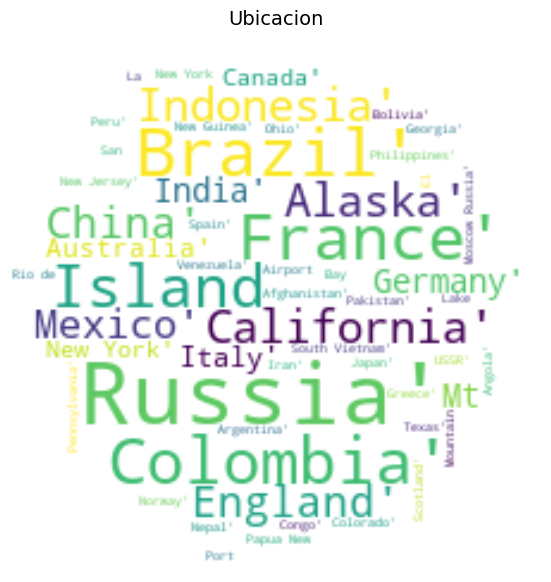

In [48]:
# Observamos una nube de palabras para ver las ubicaciones que más se repiten
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

text = str(df.location.tolist())
globe_mask = np.array(Image.open('mundo.jpg'))#colocamos una imagen para que la representacion tenga la misma forma

stopwords = set(STOPWORDS)
stopwords.add('nan')
stopwords.add('Near')

wc = WordCloud(background_color="white", max_words=2000, mask=globe_mask,
               stopwords=stopwords)
wc.generate(text)

plt.figure(figsize=(7,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('Ubicacion', loc='Center', fontsize=14)
plt.show()

In [50]:
# Modificaremos la columna 'location' para extraer el país en función a las coincidencias con la siguiente lista
lista_paises = [
    "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Antigua and Barbuda", "Argentina", "Armenia",
    "Australia", "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium",
    "Belize", "Benin", "Bhutan", "Bolivia", "Bosnia and Herzegovina", "Botswana", "Brazil", "Brunei", "Bulgaria",
    "Burkina Faso", "Burundi", "Côte d'Ivoire", "Cabo Verde", "Cambodia", "Cameroon", "Canada",
    "Central African Republic", "Chad", "Chile", "China", "Colombia", "Comoros", "Congo", "Costa Rica", "Croatia",
    "Cuba", "Cyprus", "Czech Republic", "Democratic Republic of the Congo", "Denmark", "Djibouti", "Dominica",
    "Dominican Republic", "Ecuador", "England", "Egypt", "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia",
    "Eswatini", "Ethiopia", "Fiji", "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany", "Ghana", "Greece",
    "Grenada", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana", "Haiti", "Holy See", "Honduras", "Hungary",
    "Iceland", "India", "Indonesia", "Iran", "Iraq", "Ireland", "Israel", "Italy","Ivory Coast", "Jamaica", "Japan", "Jordan",
    "Kazakhstan", "Kenya", "Kiribati", "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon", "Lesotho", "Liberia",
    "Libya", "Liechtenstein", "Lithuania", "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali",
    "Malta", "Marshall Islands", "Mauritania", "Mauritius", "Mexico", "Micronesia", "Moldova", "Monaco", "Mongolia",
    "Montenegro", "Morocco", "Mozambique", "Myanmar", "Namibia", "Nauru", "Nepal", "Netherlands", "New Zealand",
    "Nicaragua", "Nigeria", "Niger", "North Korea", "North Macedonia", "Norway", "Oman", "Pakistan", "Palau",
    "Palestine State", "Panama", "Papua", "Papua New Guinea", "Paraguay", "Peru", "Philippines", "Poland", "Portugal", "Puerto Rico",
    "Qatar", "Romania", "Russia", "Rwanda", "Saint Kitts and Nevis", "Saint Lucia",
    "Saint Vincent and the Grenadines", "Samoa", "San Marino", "Sao Tome and Principe", "Saudi Arabia", "Senegal", "Scotland",
    "Serbia", "Seychelles", "Sierra Leone", "Singapore", "Slovakia", "Slovenia", "Solomon Islands", "Somalia",
    "South Africa", "South Korea", "South Sudan", "Spain", "Sri Lanka", "Sudan", "Suriname", "Sweden", "Switzerland",
    "Syria", "Tajikistan", "Taiwan", "Tanzania", "Thailand", "Timor-Leste", "Togo", "Tonga", "Trinidad and Tobago",
    "Tunisia", "Turkey", "Turkmenistan", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates", "United Kingdom",
    "United States", "Uruguay", "USSR", "Uzbekistan", "Vanuatu", "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe"
]

In [51]:
# Esta función colocará los valores en la nueva columna 'country'
# Si no encuentra coincidencia en 'location' colocará 'other'

def obtener_pais(location):
    for pais in lista_paises:
        if pais.lower() in location.lower():
            return pais
    return 'other'

# Aplicamos la función 'obtener_pais' a la columna 'location' y creamos la columna 'country'
df['country'] = df['location'].apply(obtener_pais)

In [53]:
# Se observa que muchos de los valores de location corresponden a Estados de los Estados Unidos

# Lista de estados de los Estados Unidos
states_usa = [
    "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "Florida",
    "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine",
    "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska",
    "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio",
    "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas",
    "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
]

# Reemplazamos en  'country' el valor 'other' por 'United States'
df.loc[df['location'].str.contains('|'.join(states_usa), case=False, na=False), 'country'] = 'United States'

In [55]:
#Cantidad de Paises
df.country.nunique()

164

In [56]:

df.country.unique()

array(['United States', 'France', 'Canada', 'other', 'Germany', 'Belgium',
       'England', 'Denmark', 'Italy', 'Spain', 'Australia', 'China',
       'Morocco', 'United Kingdom', 'Oman', 'Russia', 'Colombia',
       'Hungary', 'Mauritania', 'Slovakia', 'Algeria', 'Finland',
       'Uruguay', 'Brazil', 'Netherlands', 'Greece', 'Mexico', 'Cuba',
       'Iran', 'Madagascar', 'Argentina', 'New Zealand', 'Bulgaria',
       'South Africa', 'Thailand', 'Iraq', 'Chile', 'Lebanon', 'Bolivia',
       'Ukraine', 'Peru', 'Syria', 'Pakistan', 'Egypt', 'Honduras',
       'Switzerland', 'Panama', 'Poland', 'Sweden', 'Norway', 'Croatia',
       'Tajikistan', 'Libya', 'Gambia', 'Guinea', 'Sudan', 'Samoa',
       'India', 'Tanzania', 'Kenya', 'Japan', 'Mozambique', 'Ecuador',
       'Malta', 'Indonesia', 'Scotland', 'Estonia', 'Puerto Rico',
       'Turkmenistan', 'Kazakhstan', 'Austria', 'Portugal', 'Guyana',
       'Ireland', 'Nicaragua', 'Ivory Coast', 'Philippines', 'Bahamas',
       'Liberia', 'Ni

In [58]:
# Separamos vuelos considerando si el tipo de colision (agua, tierra)
#Creamos la columna 'collision_type'

import re

# Definimos una función para asignar valores a la columna 'collision_type'
def assign_collision(location):
    if re.search(r'\bsea\b|\bocean\b|\briver\b|\bchannel\b|\bover\b', location, flags=re.IGNORECASE):
        return 'water'
    else:
        return 'ground'

# Creamos la columna 'surface' para identificar vuelos con accidentes en tierra o mar
df['collision_type'] = df['location'].apply(assign_collision)

In [60]:
df.collision_type.unique()

array(['ground', 'water'], dtype=object)

Definimos la **tasa de fatalidad de la tripulación** como el número total de tripulantes fallecidos en los accidentes registrados en la década a considerar, dividido en la cantidad total de accidentes aéreos ocurridos en este período de tiempo. Su fórmula es (Suma total de fallecidos en el período de tiempo / Suma total de accidentes en el período de tiempo).
  

In [2]:
def crew_fatality_rate(df, start_year, end_year):
    # Filtre el DataFrame para incluir solo accidentes en el período de tiempo determinado
    mask = (df['year'] >= start_year) & (df['year'] <= end_year)
    df_period = df.loc[mask]

    # Calcule el número total de muertes y accidentes de la tripulación en el período de tiempo.
    total_crew_fatalities = df_period['crew_fatalities'].sum()
    total_accidents = len(df_period)

    # Calcular la tasa de mortalidad de la tripulación.
    crew_fatality_rate = total_crew_fatalities / total_accidents

    return crew_fatality_rate
print(crew_fatality_rate)

<function crew_fatality_rate at 0x000001338A08CA60>
